In [4]:

import random
import math
from collections import namedtuple
import os
import time
import pandas as pd

import matplotlib.pyplot as plt

import torch


from utils.data_utils import *
from utils.state_CEVRP import *

from nets.Q_func import *


""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [5]:
def plot_solution(coords, mat, solution, NR_NODES, NR_CS):
    solution = solution + [0]  # Add depot at the end to complete the cycle
    arr_solution = np.array(solution)
    where = np.where(arr_solution == 0)[0]
    n_cs = NR_NODES - NR_CS

    # Set up the plot
    plt.figure(figsize=(10, 8))

    # Plot depot, customer nodes, and charging stations
    plt.scatter(coords[1:n_cs, 0], coords[1:n_cs, 1], marker='o', color="r", label='Customers')
    plt.scatter(coords[n_cs:, 0], coords[n_cs:, 1], marker='^', color="b", label='Charging Stations')
    plt.plot(coords[0, 0], coords[0, 1], '*', markersize=10, color='k', label='Depot')

    # Add node numbers next to the points
    #for i in range(NR_NODES):
        #plt.text(coords[i, 0] + 0.02, coords[i, 1] + 0.02, '{}'.format(i), fontsize=10)

    # Define a set of colors for the routes
    color = ['c', 'deeppink', 'forestgreen', 'y', 'coral', 'm', 'g', 'r', 'b', 'k', 'skyblue', 'pink', 'olive', 'purple', 'orange']

    total_distance = 0
    # Loop through each sequence in the solution
    for j in range(len(where) - 1):
        sequence = arr_solution[where[j]:where[j + 1]].tolist()  # Convert to list
        route_distance = 0  # Initialize distance for the current route

        print(f"EV path {j+1} =", sequence)

        # Calculate the total distance for the route
        for idx in range(len(sequence) - 1):
            i, next_i = sequence[idx], sequence[idx + 1]
            route_distance += mat[i, next_i]  # Sum the distances between nodes in the route

            # Draw arrows between points in the sequence with route color
            plt.arrow(coords[i, 0], coords[i, 1], coords[next_i, 0] - coords[i, 0], coords[next_i, 1] - coords[i, 1],
                      head_width=0.02, head_length=0.03, fc=color[j % len(color)], ec=color[j % len(color)], length_includes_head=True)

        # Complete the cycle by connecting the last node back to the first node (depot)
        i, next_i = sequence[-1], sequence[0]
        route_distance += mat[i, next_i]  # Add the distance back to the depot
        plt.arrow(coords[i, 0], coords[i, 1], coords[next_i, 0] - coords[i, 0], coords[next_i, 1] - coords[i, 1],
                  head_width=0.02, head_length=0.03, fc=color[j % len(color)], ec=color[j % len(color)], length_includes_head=True)

        total_distance += route_distance  # Add the route distance to the total distance

        # Add each route to the legend with relevant information
        plt.plot([], [], color=color[j % len(color)], label=f'R{j+1}, # {len(sequence)-1}, d {route_distance:.2f}')

    # Add title, legend, and display
    plt.title(f'{len(where) - 1} routes, total distance {total_distance:.2f}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()


## Inference Graph
This is the graph that will be used in the test. It's a fully connected graph

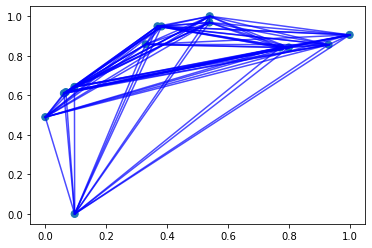

In [6]:
# Graph
NR_NODES = 14 # Number of nodes N
NR_CS = 3 # Number of charging stations n_cs
NR_EV = 3 # Number of EVs

coords, W_np = get_graph_mat(n=NR_NODES)

plot_graph(coords, W_np)

## Define the system variables
We now define the state tuple, containing a graph (given by a weights matrix `W`), the noode coordinates `coords` and the partial solution (list of visited nodes).
We also define the function `state2tens`, which translates such tuples into tensors (partially loosing the sequence order information).

In [7]:
W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)    
demands, load, soc, system_time, time_window = get_dynamics(n=NR_NODES, ncs=NR_CS)
n_cs = int(NR_NODES-NR_CS)
min_demand = min(demands[1:n_cs])
demands

tensor([0.0000, 0.2000, 0.2000, 0.2000, 0.1000, 0.0500, 0.0500, 0.0500, 0.2000,
        0.1000, 0.1000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)

## Init the model
Import the pretrained model

In [8]:
""" 
Load the pretrained model 
Get file with smallest distance
"""

fname = r'.\pretrained\ep_7000_length_4.159325275570154_.pt' 
model = torch.jit.load(fname)

# Set the model to evaluation mode (ensures proper behavior during inference)
model.eval()

# we init the Q_func 
Q_func = QFunction(model)

## Run the model

EV path 1 = [0, 1, 4, 3, 2, 7, 6, 10, 9]
EV path 2 = [0, 5, 8]


<Figure size 720x720 with 0 Axes>

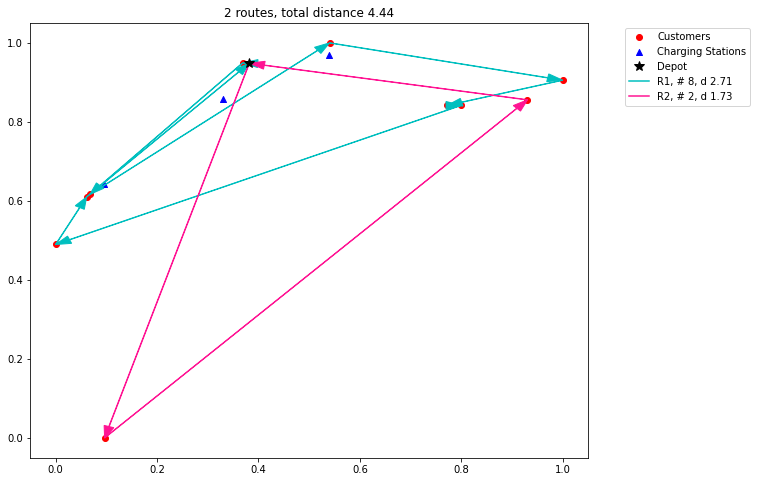

In [9]:
min_distances= []
current_new_min_dist = float('inf') 

# init solution from depot
solution = [0]

copy_demands = demands
copy_load = load
copy_soc = soc
copy_system_time=system_time

# init solution from depot
solution = [0]
# init the graph first state
current_state = State(partial_solution=solution, W=W, coords=coords, demands=copy_demands, load=copy_load, 
                    soc=copy_soc, tw=time_window, st=copy_system_time)
current_state_tsr = state2tens(current_state)
while not is_state_final(current_state, NR_EV):
    # get the new action and its Q value from model:
    next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
                                                    current_state, NR_CS, min_demand)
    # add action to solution
    solution = solution + [next_node]  
    # update the new demands and load values: visited node demand = 0
    copy_load, copy_demands, copy_soc, copy_system_time= update_length_state(current_state, next_node, NR_CS)
    # update the system state:
    current_state = State(partial_solution=solution, W=W, coords=coords, demands=copy_demands, load=copy_load, 
                    soc=copy_soc, tw=time_window, st=copy_system_time)
    current_state_tsr = state2tens(current_state)
# save the overall distance from start to finish in array
dist = total_distance(solution, W)

#print("solution", solution)

# plot solution      
plt.figure(figsize=(10,10))
plot_solution(coords, W, solution, NR_NODES, NR_CS)
#plt.title('model / len = {}'.format(dist)) 